In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import math
from scipy.stats import pearsonr
from dateutil import parser
import re

In [5]:
bike_lanes = pd.read_csv("bike_lanes.csv")
bike_lanes.head()

,NTACode,Count,Length_1,Length_T
0,BK88,10,0.802165,0.965636
1,QN52,12,0.136835,0.626597
2,QN48,102,2.167839,3.322510
3,QN51,24,0.000000,1.333101
4,QN27,42,0.433633,3.161372


In [193]:
nyc_bikeshare = pd.read_csv("nyc_bikeshare.csv")
nyc_bikeshare.tail()

,tripduration,starttime,stoptime,start_station_id,end_station_id,bikeid,usertype,birthyear,gender
27215331,665,11-30-19 23:58:27,12-01-19 00:09:32,3711.0,442.0,40402,1.0,1992.0,1
27215332,265,11-30-19 23:58:46,12-01-19 00:03:12,116.0,462.0,39333,1.0,1995.0,1
27215333,192,11-30-19 23:58:49,12-01-19 00:02:01,503.0,297.0,15543,1.0,1966.0,2
27215334,534,11-30-19 23:59:07,12-01-19 00:08:01,251.0,302.0,33020,1.0,1996.0,2
27215335,269,11-30-19 23:59:14,12-01-19 00:03:43,3534.0,3509.0,35136,1.0,1974.0,1


In [194]:
nyc_bikeshare.dropna(inplace = True)

In [195]:
nyc_bikeshare = nyc_bikeshare[nyc_bikeshare['birthyear'] > 1920]

In [196]:
nyc_bikeshare['starttime'] = pd.to_datetime(nyc_bikeshare['starttime'],format = "%m-%d-%y %H:%M:%S")

In [197]:
nyc_bikeshare['start_weekday'] = nyc_bikeshare['starttime'].dt.weekday

In [198]:
nyc_bikeshare = nyc_bikeshare[nyc_bikeshare['start_weekday'].isin([0,1,2,3,4])] # only weekdays

In [199]:
nyc_bikeshare['start_hour'] = nyc_bikeshare['starttime'].dt.hour

In [200]:
nyc_bikeshare = nyc_bikeshare[nyc_bikeshare['start_hour'].isin([6,7,8,9,10,15,16,17,18,19])] # only hours in 6-10, 15-19

In [201]:
nyc_bikeshare['start_date'] = nyc_bikeshare['starttime'].dt.date

In [202]:
nyc_bikeshare['age'] = 2020 - nyc_bikeshare['birthyear']

In [95]:
nyc_bikeshare.head()

,tripduration,starttime,stoptime,start_station_id,end_station_id,bikeid,usertype,birthyear,gender,start_weekday,start_hour,start_date,age
7557,520,2013-06-03 06:01:48,06-03-13 06:10:28,461.0,2004.0,17490,1.0,1977.0,2,0,6,2013-06-03,42.0
7560,2428,2013-06-03 06:04:44,06-03-13 06:45:12,463.0,305.0,15635,1.0,1978.0,1,0,6,2013-06-03,41.0
7562,574,2013-06-03 06:09:19,06-03-13 06:18:53,454.0,527.0,18101,1.0,1988.0,1,0,6,2013-06-03,31.0
7563,711,2013-06-03 06:11:09,06-03-13 06:23:00,466.0,520.0,18872,1.0,1970.0,1,0,6,2013-06-03,49.0
7565,1462,2013-06-03 06:18:05,06-03-13 06:42:27,347.0,457.0,19336,1.0,1982.0,1,0,6,2013-06-03,37.0


In [203]:
def age_group(age):
    '''
    input: int age
    output: string (category): age group
    '''
    if age < 18: return "U18"
    if (age >= 18) and (age <35): return "18-35"
    if (age >= 35) and (age <60): return "35-60"
    if age >= 60: return "Over60"

In [204]:
nyc_bikeshare['age_group'] = nyc_bikeshare['age'].apply(age_group)

In [205]:
nyc_bikeshare_cleaned = nyc_bikeshare.drop(columns=['starttime', 'stoptime', 'bikeid', 'start_weekday', 'start_hour', 'birthyear'])

In [206]:
nyc_bikeshare_cleaned.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age,age_group
7557,520,461.0,2004.0,1.0,2,2013-06-03,43.0,35-60
7560,2428,463.0,305.0,1.0,1,2013-06-03,42.0,35-60
7562,574,454.0,527.0,1.0,1,2013-06-03,32.0,18-35
7563,711,466.0,520.0,1.0,1,2013-06-03,50.0,35-60
7565,1462,347.0,457.0,1.0,1,2013-06-03,38.0,35-60


In [207]:
nyc_bikeshare_cleaned.to_csv("nyc_bikeshare_cleaned.csv")

In [73]:
nyc_bikeshare_subscribers = nyc_bikeshare[nyc_bikeshare["usertype"]==1]
nyc_bikeshare_others = nyc_bikeshare[nyc_bikeshare["usertype"]==0]

In [83]:
nyc_bikeshare['start_station_id'].nunique()

1036

In [133]:
subscribers_ts = nyc_bikeshare_subscribers.groupby('start_date')['tripduration'].agg('count')
others_ts = nyc_bikeshare_others.groupby('start_date')['tripduration'].agg('count')

Text(0, 0.5, 'Number of active subscriber')

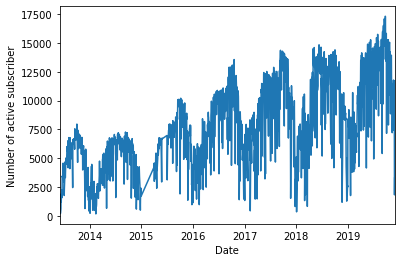

In [176]:
subscribers_ts.plot()
plt.xlabel("Date")
plt.ylabel("Number of active subscriber")

In [178]:
subscribers_ts.to_csv("bikeshare_subscribers_ts.csv", header=True)

KeyError: "None of [Index(['date', 'countActiveSubscribers'], dtype='object')] are in the [columns]"

Text(0, 0.5, 'Number of active non-subscriber')

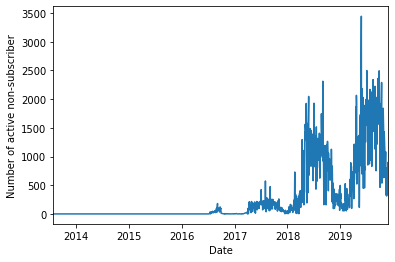

In [136]:
others_ts.plot()
plt.xlabel("Date")
plt.ylabel("Number of active non-subscriber")

In [144]:
others_ts.to_csv("bikeshare_non_subscribers_ts.csv")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [137]:
av_tripduration_ts = nyc_bikeshare.groupby(['start_date'])['tripduration'].mean()
med_tripduration_ts = nyc_bikeshare.groupby(['start_date'])['tripduration'].median()

In [145]:
av_tripduration_ts.to_csv("bikeshare_av_tripduration_ts.csv")
med_tripduration_ts.to_csv("bikeshare_med_tripduration_ts.csv")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Text(0, 0.5, 'Average trip duration (s)')

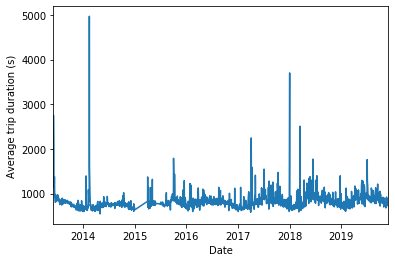

In [138]:
av_tripduration_ts.plot()
plt.xlabel("Date")
plt.ylabel("Average trip duration (s)")

Text(0, 0.5, 'Meadian of trip duration (s)')

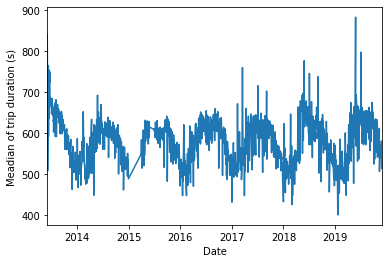

In [139]:
med_tripduration_ts.plot()
plt.xlabel("Date")
plt.ylabel("Meadian of trip duration (s)")

## Now merge with key data

In [285]:
nyc_bikeshare_key = pd.read_csv("nyc_bikeshare_key.csv")
nyc_bikeshare_key.head()

,station_id,station_name,station_latitude,station_longitude
0,72,W 52 St & 11 Ave,40.767272,-73.993929
1,79,Franklin St & W Broadway,40.719116,-74.006667
2,82,St James Pl & Pearl St,40.711174,-74.000165
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
4,116,W 17 St & 8 Ave,40.741776,-74.001497


In [286]:
nyc_bikeshare_key.columns = ["start_station_id", "station_name", "station_latitude", "station_longitude"]
nyc_bikeshare_key.drop(columns=["station_name"], inplace=True)
nyc_bikeshare_key.head()

,start_station_id,station_latitude,station_longitude
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,116,40.741776,-74.001497


In [287]:
nyc_bikeshare_cleaned.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age,age_group
7557,520,461.0,2004.0,1.0,2,2013-06-03,43.0,35-60
7560,2428,463.0,305.0,1.0,1,2013-06-03,42.0,35-60
7562,574,454.0,527.0,1.0,1,2013-06-03,32.0,18-35
7563,711,466.0,520.0,1.0,1,2013-06-03,50.0,35-60
7565,1462,347.0,457.0,1.0,1,2013-06-03,38.0,35-60


In [288]:
print(nyc_bikeshare_cleaned.shape)
print(nyc_bikeshare_key.shape)

(13177572, 8)
(1105, 3)


In [289]:
nyc_bikeshare_cleaned_mergedwithkey = nyc_bikeshare_cleaned.merge(nyc_bikeshare_key, how="left", on="start_station_id")

In [290]:
nyc_bikeshare_cleaned_mergedwithkey["start_date"] = pd.to_datetime(nyc_bikeshare_cleaned_mergedwithkey["start_date"],format="%Y-%m-%d")

In [291]:
nyc_bikeshare_cleaned_mergedwithkey.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age,age_group,station_latitude,station_longitude
0,520,461.0,2004.0,1.0,2,2013-06-03,43.0,35-60,40.735877,-73.982050
1,2428,463.0,305.0,1.0,1,2013-06-03,42.0,35-60,40.742065,-74.004432
2,574,454.0,527.0,1.0,1,2013-06-03,32.0,18-35,40.754557,-73.965930
3,711,466.0,520.0,1.0,1,2013-06-03,50.0,35-60,40.743954,-73.991449
4,1462,347.0,457.0,1.0,1,2013-06-03,38.0,35-60,40.728846,-74.008591


In [293]:
nyc_bikeshare_cleaned_mergedwithkey['nta_code'] = temp.apply(f, axis=1)

In [294]:
nyc_bikeshare_cleaned_mergedwithkey['nta_code'].nunique()

47

In [212]:
nyc_bikeshare_cleaned_mergedwithkey = nyc_bikeshare_cleaned.merge(nyc_bikeshare_key, how="left", on="start_station_id")

In [213]:
nyc_bikeshare_cleaned_mergedwithkey.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age,age_group,station_latitude,station_longitude
0,520,461.0,2004.0,1.0,2,2013-06-03,43.0,35-60,40.735877,-73.982050
1,2428,463.0,305.0,1.0,1,2013-06-03,42.0,35-60,40.742065,-74.004432
2,574,454.0,527.0,1.0,1,2013-06-03,32.0,18-35,40.754557,-73.965930
3,711,466.0,520.0,1.0,1,2013-06-03,50.0,35-60,40.743954,-73.991449
4,1462,347.0,457.0,1.0,1,2013-06-03,38.0,35-60,40.728846,-74.008591


In [214]:
from get_nta import get_nta, get_dist

In [215]:
get_nta(40.735877, 73.982050)

'QN45'

In [292]:
def f(x):    
    return get_nta(x[9], x[8])

In [217]:
nyc_bikeshare_cleaned_mergedwithkey["start_date"] = pd.to_datetime(nyc_bikeshare_cleaned_mergedwithkey["start_date"],format="%Y-%m-%d")

In [218]:
nyc_bikeshare_cleaned_mergedwithkey = nyc_bikeshare_cleaned_mergedwithkey[nyc_bikeshare_cleaned_mergedwithkey["start_date"].dt.year == 2017]

In [187]:
nyc_bikeshare_cleaned_mergedwithkey.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age_group,station_latitude,station_longitude
5183150,251,385.0,2017.0,1.0,1,2017-01-02,35-60,40.757973,-73.966033
5183151,355,519.0,3132.0,1.0,1,2017-01-02,35-60,40.751873,-73.977706
5183152,206,354.0,313.0,1.0,1,2017-01-02,18-35,40.693631,-73.962236
5183153,433,369.0,3263.0,1.0,1,2017-01-02,35-60,40.732241,-74.000264
5183154,403,151.0,152.0,1.0,1,2017-01-02,35-60,40.722104,-73.997249


In [221]:
nyc_bikeshare_cleaned_mergedwithkey['nta_code'] = nyc_bikeshare_cleaned_mergedwithkey.apply(f, axis=1)

In [271]:
nyc_bikeshare_cleaned_mergedwithkey.head()

,tripduration,start_station_id,end_station_id,usertype,gender,start_date,age,age_group,station_latitude,station_longitude
0,520,461.0,2004.0,1.0,2,2013-06-03,43.0,35-60,40.735877,-73.982050
1,2428,463.0,305.0,1.0,1,2013-06-03,42.0,35-60,40.742065,-74.004432
2,574,454.0,527.0,1.0,1,2013-06-03,32.0,18-35,40.754557,-73.965930
3,711,466.0,520.0,1.0,1,2013-06-03,50.0,35-60,40.743954,-73.991449
4,1462,347.0,457.0,1.0,1,2013-06-03,38.0,35-60,40.728846,-74.008591


In [229]:
bs_av_trip_duration = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['tripduration'].mean()
bs_av_trip_duration

nta_code
BK09     1150.826646
BK31     1268.564748
BK32     1184.273021
BK33     1009.445385
BK35    10717.415385
BK37      889.488169
BK38     1043.459924
BK40      785.079676
BK61     7537.270767
BK63     1169.969136
BK64      994.812594
BK68      816.273297
BK69     3377.170657
BK72     1572.375970
BK73      716.777558
BK75     3772.533065
BK76      755.483215
BK78     1102.430451
BX22      925.000000
MN09     1035.079002
MN11      871.484568
MN12     1113.259088
MN13      777.481385
MN14      878.282640
MN15      915.990632
MN17      782.975353
MN19      794.922905
MN20      728.203969
MN21      792.504731
MN22      780.293205
MN23      690.816628
MN24      815.399621
MN25     1091.873433
MN27      765.533589
MN28      901.185120
MN31      869.400471
MN33      767.447462
MN40      886.694235
MN50      761.679985
MN99      960.576808
QN15      601.538462
QN31      962.244564
QN63      953.456621
QN68      693.623910
QN70      578.665185
QN71     1105.331579
Name: tripduration, dtype

In [230]:
bs_med_trip_duration = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['tripduration'].median()
bs_med_trip_duration

nta_code
BK09     468.0
BK31    1136.0
BK32     606.0
BK33     481.0
BK35     553.0
BK37     468.0
BK38     639.0
BK40     451.0
BK61     869.5
BK63     680.0
BK64     540.0
BK68     484.0
BK69     659.5
BK72     511.0
BK73     398.0
BK75     677.0
BK76     410.0
BK78     771.5
BX22     882.0
MN09     782.5
MN11     610.0
MN12     941.0
MN13     603.0
MN14     684.0
MN15     700.0
MN17     619.0
MN19     640.0
MN20     572.0
MN21     537.0
MN22     571.0
MN23     517.0
MN24     608.0
MN25     793.0
MN27     636.0
MN28     696.0
MN31     745.0
MN33     473.0
MN40     710.0
MN50     642.0
MN99     576.0
QN15     609.0
QN31     641.0
QN63     696.0
QN68     461.0
QN70     353.0
QN71     317.5
Name: tripduration, dtype: float64

In [231]:
bs_med_age = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['age'].median()
bs_med_age

nta_code
BK09    42.0
BK31    33.0
BK32    40.0
BK33    40.0
BK35    38.0
BK37    40.0
BK38    37.0
BK40    44.0
BK61    35.0
BK63    35.0
BK64    38.0
BK68    38.0
BK69    35.0
BK72    34.0
BK73    36.0
BK75    34.0
BK76    37.0
BK78    33.0
BX22    36.0
MN09    37.0
MN11    38.0
MN12    42.0
MN13    41.0
MN14    43.0
MN15    40.0
MN17    42.0
MN19    41.0
MN20    39.0
MN21    37.0
MN22    34.0
MN23    38.0
MN24    38.0
MN25    40.0
MN27    37.0
MN28    38.0
MN31    39.0
MN33    36.0
MN40    39.0
MN50    36.0
MN99    40.0
QN15    28.0
QN31    38.0
QN63    33.0
QN68    36.0
QN70    35.0
QN71    37.0
Name: age, dtype: float64

In [232]:
bs_av_age = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['age'].mean()
bs_av_age

nta_code
BK09    43.270810
BK31    36.517986
BK32    42.111908
BK33    41.862724
BK35    39.619910
BK37    41.792516
BK38    39.498804
BK40    44.869807
BK61    37.560703
BK63    37.215168
BK64    40.666916
BK68    39.680411
BK69    37.225034
BK72    36.309876
BK73    37.810542
BK75    35.772193
BK76    38.086525
BK78    35.033083
BX22    35.166667
MN09    40.025988
MN11    40.982853
MN12    43.513223
MN13    42.567728
MN14    44.661290
MN15    41.869061
MN17    43.039201
MN19    42.937597
MN20    41.315038
MN21    40.070229
MN22    38.402218
MN23    41.177822
MN24    41.037752
MN25    42.054964
MN27    40.635770
MN28    40.315611
MN31    41.817793
MN33    38.861964
MN40    41.893402
MN50    39.192937
MN99    41.920862
QN15    34.000000
QN31    39.682474
QN63    36.570776
QN68    38.269406
QN70    37.074074
QN71    38.690351
Name: age, dtype: float64

In [235]:
bs_male_proportion = nyc_bikeshare_cleaned_mergedwithkey[nyc_bikeshare_cleaned_mergedwithkey["gender"]==1].groupby('nta_code')['gender'].count()/nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['gender'].count()
bs_male_proportion

nta_code
BK09    0.689378
BK31    0.874101
BK32    0.691972
BK33    0.710704
BK35    0.670588
BK37    0.718720
BK38    0.658490
BK40    0.673250
BK61    0.732428
BK63    0.698413
BK64    0.676332
BK68    0.683163
BK69    0.665253
BK72    0.694361
BK73    0.691409
BK75    0.678532
BK76    0.670922
BK78    0.728195
BX22    1.000000
MN09    0.678015
MN11    0.713992
MN12    0.666568
MN13    0.815603
MN14    0.714200
MN15    0.780733
MN17    0.825025
MN19    0.817873
MN20    0.802260
MN21    0.775497
MN22    0.713128
MN23    0.750504
MN24    0.731106
MN25    0.750169
MN27    0.675501
MN28    0.724835
MN31    0.740848
MN33    0.691101
MN40    0.734502
MN50    0.711174
MN99    0.630357
QN15    0.923077
QN31    0.766756
QN63    0.598174
QN68    0.720216
QN70    0.666667
QN71    0.743860
Name: gender, dtype: float64

In [236]:
bs_subscriber_proportion = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['usertype'].mean()
bs_subscriber_proportion

nta_code
BK09    0.984736
BK31    1.000000
BK32    0.988894
BK33    0.990280
BK35    0.981900
BK37    0.991597
BK38    0.983183
BK40    0.990590
BK61    0.948083
BK63    0.971781
BK64    0.988284
BK68    0.990531
BK69    0.976402
BK72    0.981744
BK73    0.989039
BK75    0.963633
BK76    0.992908
BK78    0.983459
BX22    1.000000
MN09    0.985967
MN11    0.987997
MN12    0.978646
MN13    0.989883
MN14    0.978198
MN15    0.989819
MN17    0.986441
MN19    0.992065
MN20    0.991526
MN21    0.993147
MN22    0.994187
MN23    0.991539
MN24    0.986928
MN25    0.983351
MN27    0.993625
MN28    0.975716
MN31    0.993700
MN33    0.991430
MN40    0.982990
MN50    0.994458
MN99    0.985410
QN15    1.000000
QN31    0.987575
QN63    1.000000
QN68    0.988792
QN70    0.989630
QN71    0.988596
Name: usertype, dtype: float64

In [237]:
bs_number_rides = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['gender'].count()
bs_number_rides

nta_code
BK09     19065
BK31       278
BK32      7113
BK33     57512
BK35      1105
BK37     42008
BK38     12963
BK40     16153
BK61      1252
BK63      1134
BK64     18692
BK68     24713
BK69     14620
BK72     25252
BK73     59211
BK75     11659
BK76      6345
BK78      2660
BX22         6
MN09      3848
MN11      2916
MN12     50670
MN13    271230
MN14    103478
MN15     41844
MN17    207978
MN19     88345
MN20    104673
MN21    118043
MN22     67267
MN23    403983
MN24    269125
MN25    100848
MN27     79535
MN28     23266
MN31     32699
MN33      7585
MN40     45620
MN50      7759
MN99     13091
QN15        13
QN31     14487
QN63       219
QN68      2409
QN70       675
QN71      1140
Name: gender, dtype: int64

In [238]:
bs_number_startstation = nyc_bikeshare_cleaned_mergedwithkey.groupby('nta_code')['start_station_id'].nunique()
bs_number_startstation

nta_code
BK09    10
BK31     4
BK32    11
BK33    31
BK35     1
BK37    27
BK38     7
BK40    13
BK61     2
BK63    14
BK64    17
BK68    15
BK69    20
BK72    20
BK73    33
BK75    16
BK76     3
BK78     2
BX22     1
MN09    17
MN11    16
MN12    29
MN13    36
MN14    27
MN15     9
MN17    42
MN19    17
MN20    16
MN21    14
MN22    13
MN23    54
MN24    54
MN25    23
MN27    22
MN28    10
MN31    17
MN33    14
MN40    26
MN50     2
MN99    25
QN15     3
QN31    30
QN63     2
QN68    20
QN70     5
QN71    12
Name: start_station_id, dtype: int64

In [240]:
bs_number_startstation.index

Index(['BK09', 'BK31', 'BK32', 'BK33', 'BK35', 'BK37', 'BK38', 'BK40', 'BK61',
       'BK63', 'BK64', 'BK68', 'BK69', 'BK72', 'BK73', 'BK75', 'BK76', 'BK78',
       'BX22', 'MN09', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN17', 'MN19',
       'MN20', 'MN21', 'MN22', 'MN23', 'MN24', 'MN25', 'MN27', 'MN28', 'MN31',
       'MN33', 'MN40', 'MN50', 'MN99', 'QN15', 'QN31', 'QN63', 'QN68', 'QN70',
       'QN71'],
      dtype='object', name='nta_code')

In [245]:
df_regression_bs = pd.concat([bs_av_trip_duration, bs_med_trip_duration, 
           bs_med_age, bs_av_age, bs_male_proportion, 
           bs_subscriber_proportion, bs_number_rides, bs_number_startstation], axis = 1)
df_regression_bs

,tripduration,tripduration,age,age,gender,usertype,gender,start_station_id
nta_code,,,,,,,,
BK09,1150.826646,468.0,42.0,43.270810,0.689378,0.984736,19065,10
BK31,1268.564748,1136.0,33.0,36.517986,0.874101,1.000000,278,4
BK32,1184.273021,606.0,40.0,42.111908,0.691972,0.988894,7113,11
BK33,1009.445385,481.0,40.0,41.862724,0.710704,0.990280,57512,31
BK35,10717.415385,553.0,38.0,39.619910,0.670588,0.981900,1105,1
BK37,889.488169,468.0,40.0,41.792516,0.718720,0.991597,42008,27
BK38,1043.459924,639.0,37.0,39.498804,0.658490,0.983183,12963,7
BK40,785.079676,451.0,44.0,44.869807,0.673250,0.990590,16153,13
BK61,7537.270767,869.5,35.0,37.560703,0.732428,0.948083,1252,2


In [247]:
df_regression_bs = df_regression_bs.reset_index()
df_regression_bs

,nta_code,tripduration,tripduration,age,age,gender,usertype,gender,start_station_id
0,BK09,1150.826646,468.0,42.0,43.270810,0.689378,0.984736,19065,10
1,BK31,1268.564748,1136.0,33.0,36.517986,0.874101,1.000000,278,4
2,BK32,1184.273021,606.0,40.0,42.111908,0.691972,0.988894,7113,11
3,BK33,1009.445385,481.0,40.0,41.862724,0.710704,0.990280,57512,31
4,BK35,10717.415385,553.0,38.0,39.619910,0.670588,0.981900,1105,1
5,BK37,889.488169,468.0,40.0,41.792516,0.718720,0.991597,42008,27
6,BK38,1043.459924,639.0,37.0,39.498804,0.658490,0.983183,12963,7
7,BK40,785.079676,451.0,44.0,44.869807,0.673250,0.990590,16153,13
8,BK61,7537.270767,869.5,35.0,37.560703,0.732428,0.948083,1252,2
9,BK63,1169.969136,680.0,35.0,37.215168,0.698413,0.971781,1134,14


In [248]:
df_regression_bs.columns = ["nta_code", "bs_av_trip_duration", "bs_med_trip_duration", 
           "bs_med_age", "bs_av_age", "bs_male_proportion", 
           "bs_subscriber_proportion", "bs_number_rides", "bs_number_startstation"]
df_regression_bs

,nta_code,bs_av_trip_duration,bs_med_trip_duration,bs_med_age,bs_av_age,bs_male_proportion,bs_subscriber_proportion,bs_number_rides,bs_number_startstation
0,BK09,1150.826646,468.0,42.0,43.270810,0.689378,0.984736,19065,10
1,BK31,1268.564748,1136.0,33.0,36.517986,0.874101,1.000000,278,4
2,BK32,1184.273021,606.0,40.0,42.111908,0.691972,0.988894,7113,11
3,BK33,1009.445385,481.0,40.0,41.862724,0.710704,0.990280,57512,31
4,BK35,10717.415385,553.0,38.0,39.619910,0.670588,0.981900,1105,1
5,BK37,889.488169,468.0,40.0,41.792516,0.718720,0.991597,42008,27
6,BK38,1043.459924,639.0,37.0,39.498804,0.658490,0.983183,12963,7
7,BK40,785.079676,451.0,44.0,44.869807,0.673250,0.990590,16153,13
8,BK61,7537.270767,869.5,35.0,37.560703,0.732428,0.948083,1252,2
9,BK63,1169.969136,680.0,35.0,37.215168,0.698413,0.971781,1134,14


In [249]:
df_regression_bs.to_csv("df_regression_bs.csv")

In [263]:
df_regression_bs.tail()

,nta_code,bs_av_trip_duration,bs_med_trip_duration,bs_med_age,bs_av_age,bs_male_proportion,bs_subscriber_proportion,bs_number_rides,bs_number_startstation
41,QN31,962.244564,641.0,38.0,39.682474,0.766756,0.987575,14487,30
42,QN63,953.456621,696.0,33.0,36.570776,0.598174,1.000000,219,2
43,QN68,693.623910,461.0,36.0,38.269406,0.720216,0.988792,2409,20
44,QN70,578.665185,353.0,35.0,37.074074,0.666667,0.989630,675,5
45,QN71,1105.331579,317.5,37.0,38.690351,0.743860,0.988596,1140,12


In [258]:
df_regression_bs.corr()

,bs_av_trip_duration,bs_med_trip_duration,bs_med_age,bs_av_age,bs_male_proportion,bs_subscriber_proportion,bs_number_rides,bs_number_startstation
bs_av_trip_duration,1.000000,0.139329,-0.114759,-0.171674,-0.150607,-0.553833,-0.184163,-0.265293
bs_med_trip_duration,0.139329,1.000000,-0.121919,-0.106539,0.345125,-0.187401,-0.080356,-0.154862
bs_med_age,-0.114759,-0.121919,1.000000,0.945857,-0.130397,-0.050863,0.322375,0.430904
bs_av_age,-0.171674,-0.106539,0.945857,1.000000,-0.164823,0.013198,0.392959,0.481452
bs_male_proportion,-0.150607,0.345125,-0.130397,-0.164823,1.000000,0.312580,0.212771,-0.016196
bs_subscriber_proportion,-0.553833,-0.187401,-0.050863,0.013198,0.312580,1.000000,0.102125,-0.021763
bs_number_rides,-0.184163,-0.080356,0.322375,0.392959,0.212771,0.102125,1.000000,0.785795
bs_number_startstation,-0.265293,-0.154862,0.430904,0.481452,-0.016196,-0.021763,0.785795,1.000000


In [264]:
bike_lanes = pd.read_csv("bike_lanes.csv")
bike_lanes.columns = ["nta_code", "Count", "Length_1", "Length_T"]

In [265]:
bike_lanes.head()

,nta_code,Count,Length_1,Length_T
0,BK88,10,0.802165,0.965636
1,QN52,12,0.136835,0.626597
2,QN48,102,2.167839,3.322510
3,QN51,24,0.000000,1.333101
4,QN27,42,0.433633,3.161372


In [266]:
df_lanesMerged = df_regression_bs.merge(bike_lanes, how="inner", on="nta_code")
df_lanesMerged

,nta_code,bs_av_trip_duration,bs_med_trip_duration,bs_med_age,bs_av_age,bs_male_proportion,bs_subscriber_proportion,bs_number_rides,bs_number_startstation,Count,Length_1,Length_T
0,BK09,1150.826646,468.0,42.0,43.270810,0.689378,0.984736,19065,10,104,0.298588,7.784189
1,BK31,1268.564748,1136.0,33.0,36.517986,0.874101,1.000000,278,4,253,2.239036,18.393535
2,BK32,1184.273021,606.0,40.0,42.111908,0.691972,0.988894,7113,11,126,0.855966,11.260442
3,BK33,1009.445385,481.0,40.0,41.862724,0.710704,0.990280,57512,31,269,1.459791,18.746580
4,BK35,10717.415385,553.0,38.0,39.619910,0.670588,0.981900,1105,1,146,0.000000,10.418583
5,BK37,889.488169,468.0,40.0,41.792516,0.718720,0.991597,42008,27,157,0.000000,15.522355
6,BK38,1043.459924,639.0,37.0,39.498804,0.658490,0.983183,12963,7,91,2.308848,5.305298
7,BK40,785.079676,451.0,44.0,44.869807,0.673250,0.990590,16153,13,132,3.447716,10.392647
8,BK61,7537.270767,869.5,35.0,37.560703,0.732428,0.948083,1252,2,165,0.044223,13.336362
9,BK63,1169.969136,680.0,35.0,37.215168,0.698413,0.971781,1134,14,133,3.214282,16.574086


In [268]:
df_lanesMerged.corr()["Length_1"]

bs_av_trip_duration        -0.283553
bs_med_trip_duration        0.019259
bs_med_age                  0.244940
bs_av_age                   0.334505
bs_male_proportion          0.094552
bs_subscriber_proportion    0.106886
bs_number_rides             0.686167
bs_number_startstation      0.645180
Count                       0.662343
Length_1                    1.000000
Length_T                    0.640258
Name: Length_1, dtype: float64

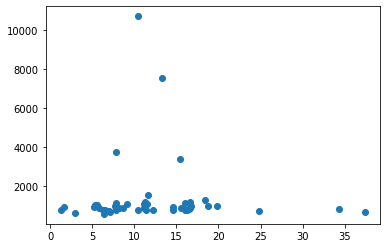

In [272]:
plt.scatter(df_lanesMerged["Length_T"], df_lanesMerged["bs_av_trip_duration"])

In [273]:
import os
import folium
import json
import requests

m = folium.Map([40.5, -74.2], zoom_start=10)

In [274]:
bkln_data = pd.read_csv('bike_lanes.csv')

In [276]:
bkln_data.columns = ["nta_code","Count","Length_1","Length_T"]

In [277]:
bkln_data

,nta_code,Count,Length_1,Length_T
0,BK88,10,0.802165,0.965636
1,QN52,12,0.136835,0.626597
2,QN48,102,2.167839,3.322510
3,QN51,24,0.000000,1.333101
4,QN27,42,0.433633,3.161372
5,BX35,90,0.045144,6.701682
6,BX98,0,0.000000,0.000000
7,QN07,0,0.000000,0.000000
8,MN06,64,0.187500,3.003897
9,QN02,0,0.000000,0.000000


In [296]:
df_regression_bs

,nta_code,bs_av_trip_duration,bs_med_trip_duration,bs_med_age,bs_av_age,bs_male_proportion,bs_subscriber_proportion,bs_number_rides,bs_number_startstation
0,BK09,1150.826646,468.0,42.0,43.270810,0.689378,0.984736,19065,10
1,BK31,1268.564748,1136.0,33.0,36.517986,0.874101,1.000000,278,4
2,BK32,1184.273021,606.0,40.0,42.111908,0.691972,0.988894,7113,11
3,BK33,1009.445385,481.0,40.0,41.862724,0.710704,0.990280,57512,31
4,BK35,10717.415385,553.0,38.0,39.619910,0.670588,0.981900,1105,1
5,BK37,889.488169,468.0,40.0,41.792516,0.718720,0.991597,42008,27
6,BK38,1043.459924,639.0,37.0,39.498804,0.658490,0.983183,12963,7
7,BK40,785.079676,451.0,44.0,44.869807,0.673250,0.990590,16153,13
8,BK61,7537.270767,869.5,35.0,37.560703,0.732428,0.948083,1252,2
9,BK63,1169.969136,680.0,35.0,37.215168,0.698413,0.971781,1134,14


In [279]:
df = df_regression_bs.merge(bkln_data, how="left", on="nta_code")

In [297]:
folium.Choropleth(
    geo_data='nta.json',
    name='choropleth',
    data=bkln_data,
    columns=['NTACode', 'Length_1'],
    key_on='feature.properties.NTACode',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Class I Bike Path Length [km]'
).add_to(m)

ValueError: key_on `'properties.nta_code'` not found in GeoJSON.